#### Display related

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def show_state(observation, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(observation, cmap='gray')
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()

#### Preprocessing

In [2]:
# import cv2
from skimage.transform import resize
import numpy as np

def downsize(img_arry):
    img_arry = resize(img_arry, (84, 84), anti_aliasing=True)
    return img_arry # [:,:84]

def rgb2gray(img_arr):
    return np.dot(img_arr[...,:3], [0.299, 0.587, 0.114])

def preprocess_image(img_arr):
    downsized = downsize(observation)
    return rgb2gray(downsized)

def transform_reward(reward):
        return np.sign(reward)

In [3]:
class RingBuf:
    def __init__(self, size):
        # Pro-tip: when implementing a ring buffer, always allocate one extra element,
        # this way, self.start == self.end always means the buffer is EMPTY, whereas
        # if you allocate exactly the right number of elements, it could also mean
        # the buffer is full. This greatly simplifies the rest of the code.
        self.data = [None] * (size + 1)
        self.start = 0
        self.end = 0
        
    def append(self, element):
        self.data[self.end] = element
        self.end = (self.end + 1) % len(self.data)
        # end == start and yet we just added one element. This means the buffer has one
        # too many element. Remove the first element by incrementing start.
        if self.end == self.start:
            self.start = (self.start + 1) % len(self.data)
        
    def __getitem__(self, idx):
        return self.data[(self.start + idx) % len(self.data)]
    
    def __len__(self):
        if self.end < self.start:
            return self.end + len(self.data) - self.start
        else:
            return self.end - self.start
        
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten


def atari_model(action_size, state_size):
    model = Sequential()
    model.add(Conv2D(16,
                            8,
                            strides=(4, 4),
                            padding="valid",
                            activation="relu",
                            input_shape=state_size,
                            data_format="channels_first"))
    model.add(Conv2D(32,
                            4,
                            strides=(2, 2),
                            padding="valid",
                            activation="relu",
                            input_shape=state_size,
                            data_format="channels_first"))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(action_size))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

ModuleNotFoundError: No module named 'keras'

In [13]:
def fit_batch(model, gamma, start_states, actions, rewards, next_states, is_terminal):
    """
    Do one deep Q learning iteration.

    Params:
    - model: The DQN
    - gamma: Discount factor (should be 0.99)
    - start_states: numpy array of starting states
    - actions: numpy array of one-hot encoded actions corresponding to the start states
    - rewards: numpy array of rewards corresponding to the start states and actions
    - next_states: numpy array of the resulting states corresponding to the start states and actions
    - is_terminal: numpy boolean array of whether the resulting state is terminal

    """
    # First, predict the Q values of the next states. Note how we are passing ones as the mask.
    next_Q_values = model.predict([next_states, np.ones(actions.shape)])
    # The Q values of the terminal states is 0 by definition, so override them
    next_Q_values[is_terminal] = 0
    # The Q values of each start state is the reward + gamma * the max next state Q value
    Q_values = rewards + gamma * np.max(next_Q_values, axis=1)
    # Fit the keras model. Note how we are passing the actions as the mask and multiplying
    # the targets by the actions.
    model.fit(
        [start_states, actions], actions * Q_values[:, None],
        nb_epoch=1, batch_size=len(start_states), verbose=0
    )
    return model

In [14]:
def q_iteration(env, model, state, iteration, memory):
    # Choose epsilon based on the iteration
    epsilon = iteration # get_epsilon_for_iteration(iteration)

    # Choose the action 
    if random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = choose_best_action(model, state)

    # Play one game iteration (note: according to the next paper, you should actually play 4 times here)
    new_frame, reward, is_done, _ = env.step(action)
    memory.add(state, action, new_frame, reward, is_done)

    # Sample and fit
    batch = memory.sample_batch(32)
    model = fit_batch(model, batch)
    return model
    
def choose_best_action(model, state):
    print(state)
    actions = model.predict(state)
    action = np.argmax(actions)
    return action

#### Main loop

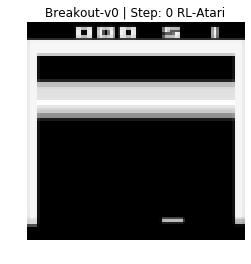

ValueError: Error when checking input: expected conv2d_15_input to have 4 dimensions, but got array with shape (84, 84)

In [23]:
import gym
import random
env = gym.make("Breakout-v0")
observation = env.reset()

alpha = 0.1
gamma = 0.99
epsilon = 0.1
# itertion = 0
model = atari_model(env.action_space.n, (4,84,84))
ring_buffer = RingBuf(size=10000)

for t in range(500):
    observation = env.render(mode='rgb_array')
    state = preprocess_image(observation)
    show_state(state, 0, "RL-Atari")
    
    q_iteration(env, model, state, epsilon, ring_buffer)
    action = env.action_space.sample() # your agent here (this takes random actions)
    observation, reward, done, info = env.step(action)
    

In [ ]:
for i in range(1, 100001):
#     state = env.reset()

#     epochs, penalties, reward, = 0, 0, 0
#     done = False
    
    while not done:
        
        q_iteration(env, model, state, epsilon, memory)
#         if random.uniform(0, 1) < epsilon:
#             action = env.action_space.sample() # Explore action space
#         else:
#             action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")